[Baseline from Wilson](https://arxiv.org/pdf/2002.08791.pdf)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from utilities import *

## Data

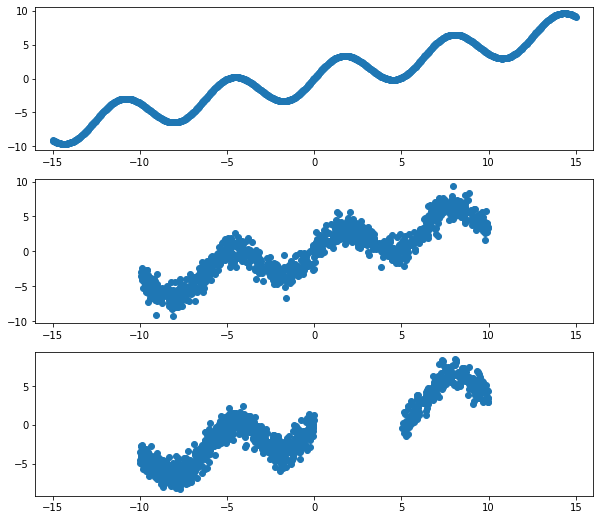

In [2]:
DG = DataGenerator(slope=0.5, amplitude=2.5, frequency=1.0, noise=1.0)

plt.figure(figsize=(10, 9))

plt.subplot(311)
x, y = DG.generate_mean_function(bounds=(-15, 15))
plt.scatter(x[:, 0], y[:, 0])
plt.xlim(-16, 16)

plt.subplot(312)
x, y = DG.generate_sample_data(1000)
plt.scatter(x[:, 0], y[:, 0])
plt.xlim(-16, 16)

plt.subplot(313)
x, y = DG.generate_sample_data(1000, gap=True)
plt.scatter(x[:, 0], y[:, 0])
plt.xlim(-16, 16)

plt.show()

## Gaussian Process

## MCMC Example

In [ ]:
model = BayesianNN()

x, y = DG.generate_sample_data(1000)
model.fit(x, y, 1000)

new_x, new_y = DG.generate_mean_function(bounds=(-15, 15))
posterior = model.sample_posterior(new_x, 500)

In [ ]:
# ann_input.set_value(new_x)
# ppc = pm.sample_ppc(trace, model=neural_network, samples=500)
# y_pred = ppc["out"].mean(axis=0)[:, None]

In [ ]:
plt.figure(figsize=(10, 4))

MAP = np.percentile(posterior, 50, axis=0)
plt.plot(new_x, MAP)

lb = np.percentile(posterior, 2.5, axis=0)
ub = np.percentile(posterior, 97.5, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

lb = np.percentile(posterior, 20, axis=0)
ub = np.percentile(posterior, 80, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

plt.scatter(x, y)
plt.plot(new_x, new_y)

plt.show()

## VI Example

In [3]:
model = BayesianNN()

x, y = DG.generate_sample_data(100)
model.fit(x, y, 5000, VI=True)

new_x, new_y = DG.generate_mean_function(bounds=(-15, 15))
posterior = model.sample_posterior(new_x, 500)

100%|██████████| 10000/10000 [01:30<00:00, 109.99it/s]


In [9]:
new_x = np.linspace(-15, 15, 100)[:, None].astype("float32")
posterior = model.sample_posterior(new_x, 500)

ValueError: x and y must have same first dimension, but have shapes (100, 1) and (1000, 1)

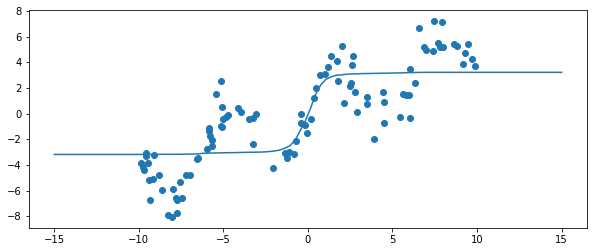

In [11]:
plt.figure(figsize=(10, 4))

MAP = np.percentile(posterior, 50, axis=0)
plt.plot(new_x, MAP)

# lb = np.percentile(posterior, 2.5, axis=0)
# ub = np.percentile(posterior, 97.5, axis=0)
# plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

# lb = np.percentile(posterior, 20, axis=0)
# ub = np.percentile(posterior, 80, axis=0)
# plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

plt.scatter(x, y)
plt.plot(new_x, new_y)

plt.show()

## MCDropout Example

## Ensemble Example

In [ ]:
input_dim = x.shape[1]
output_dim = y.shape[1]

ann_input = theano.shared(x)
ann_output = theano.shared(y)

n_hidden = 3
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(input_dim, n_hidden))#, testval=init_1)
    weights_b_1 = pm.Normal('w_b_1', 0, sd=1, shape=(n_hidden))#, testval=init_b_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden))#, testval=init_2)
    weights_b_2 = pm.Normal('w_b_2', 0, sd=1, shape=(n_hidden))#, testval=init_b_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden, output_dim))#, testval=init_out)
    weights_b_out = pm.Normal('w_b_out', 0, sd=1, shape=(output_dim))#, testval=init_b_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + weights_b_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + weights_b_2)
    act_out = pm.math.dot(act_2, weights_2_out) + weights_b_out
        
    variance = pm.HalfNormal('uncertainty', sigma=3.0)    
    out = pm.Normal('out', mu=act_out, 
                    sigma=variance, 
                    observed=ann_output)

In [ ]:
with neural_network:
    
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     #s.set_value(0)
#     approx = pm.fit(n=20000, method=inference)
#     trace = approx.sample(draws=5000)

    approx = pm.fit(n=20000, method='svgd')
    trace = approx.sample(draws=10000)

In [ ]:
def sample_posterior(x, trace, samples):
    posterior_samples = trace['w_in_1'].shape[0]
    output = []
    for _ in range(samples):
        i = np.random.randint(posterior_samples)
        act_1 = np.tanh(np.dot(x, trace['w_in_1'][i]) + trace['w_b_1'][i])
        act_2 = np.tanh(np.dot(act_1, trace['w_1_2'][i]) + trace['w_b_2'][i])
        y = np.dot(act_2, trace['w_2_out'][i]) + trace['w_b_out'][i]
        output.append(y)
    return np.asarray(output)

new_x = np.linspace(-15, 15, 100)[:, None].astype("float32")
posterior = sample_posterior(new_x,  trace, 500)

In [ ]:
plt.figure(figsize=(10, 4))

MAP = np.percentile(posterior, 50, axis=0)
plt.plot(new_x, MAP)

lb = np.percentile(posterior, 2.5, axis=0)
ub = np.percentile(posterior, 97.5, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

lb = np.percentile(posterior, 20, axis=0)
ub = np.percentile(posterior, 80, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

plt.scatter(x, y)

plt.show()